In [1]:
# %pip install pandas networkx numpy os torch torch_geometric node2vec scipy matplotlib

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import os.path as osp
# import torch
from torch_geometric.datasets import Planetoid
from node2vec import Node2Vec

from scipy.spatial.distance import pdist
from scipy import linalg

import matplotlib.pyplot as plt

## Data Import

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]

In [4]:
data.node_attrs

<bound method BaseData.node_attrs of Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])>

## Generate Networkx Graph

In [5]:
# Create a NetworkX graph from the PyTorch Geometric dataset
G = nx.Graph()
for i, j in data.edge_index.t().tolist():
    G.add_edge(i, j)

## Generate Vector Embeddings using Node2vec

In [6]:
# Create an instance of the Node2Vec model
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4)

# Fit the model to the random walks
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings for each paper node
paper_embeddings = {str(node): model.wv[str(node)] for node in range(data.num_nodes)}

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

In [8]:
len(list(paper_embeddings.values())[1])

128

## Proximity Between Vector Embeddings

In [9]:
vec_df = pd.DataFrame(paper_embeddings)
vec_df = vec_df.T

In [10]:
vec_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.077769,0.236704,0.064671,-0.263464,-0.082558,-0.140774,0.084701,0.190177,0.062964,0.190074,...,-0.125814,0.286736,0.344979,-0.302014,0.046241,0.212311,-0.591915,0.195987,-0.804964,-0.410228
1,-0.467793,0.281748,0.552697,0.454733,0.591621,-0.189358,-0.181961,0.056450,-0.312305,0.215746,...,0.132198,0.315504,0.004474,-0.497878,-0.834289,-0.015181,-0.410300,-0.388667,-0.320374,-0.737702
2,-0.279440,-0.024468,0.479396,0.241130,0.579024,-0.025062,0.033053,0.099407,-0.129933,-0.036946,...,0.065318,0.124606,-0.036084,-0.270287,-0.209992,0.117132,-0.255100,-0.310485,-0.103983,-0.510650
3,-0.508314,0.564944,0.068488,-0.398234,0.055599,-0.556242,-0.211953,0.200815,0.295404,0.673404,...,1.041917,-1.115387,-0.103097,-0.270923,0.460429,0.003617,-0.491058,0.599199,0.175022,-0.954014
4,-0.403625,-0.036202,-0.264535,-0.062133,0.359478,0.005810,0.084046,0.002409,0.231728,0.555691,...,-0.652470,-0.279824,-0.477373,-0.407446,-0.000903,0.155919,0.690353,0.923121,-0.805374,-0.284457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,-0.364300,0.092713,0.064545,-0.284245,0.743611,0.106637,0.033660,0.352792,-0.104682,0.318777,...,0.265878,0.013315,-0.131863,-0.525839,-0.079871,-0.001970,0.060939,0.130234,-0.346551,-0.343271
2704,-0.528363,0.031556,0.201024,-0.188551,1.279812,-0.311632,0.411313,0.203920,0.017622,1.360356,...,0.504239,0.074917,0.201922,-0.227525,-1.002662,0.051023,0.065017,0.114165,0.077925,-0.750785
2705,-1.312979,-0.077811,0.006763,0.093945,0.413037,-0.060710,-0.187744,-0.452263,-0.130972,-0.245573,...,-0.038115,0.493976,0.155922,0.295417,-0.343341,-0.238324,0.119737,-0.184396,-0.189299,-0.311372
2706,-0.434766,-0.506532,0.460523,-0.296975,0.174480,0.462239,-0.146198,-0.296322,0.396681,0.344033,...,0.114458,0.134418,-0.086635,-0.030928,0.321525,0.477931,-0.128001,0.417263,-0.575216,-0.443046


#### Distance Matrix

In [11]:
# Pairwise distances
dimension = vec_df.shape[0]
dist_ = pdist(vec_df)
dist_mat = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        dist_mat[i,j] = d
        dist_mat[j,i] = d

In [12]:
len(dist_mat)

2708

#### Adjacency/ Similarity Matrix (Self-Tuning Spectral Clustering Algorithm)

In [13]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in range(len(dist_mat)):
    sigmas[i] = sorted(dist_mat[i])[7]

In [14]:
sigmas

array([2.62623029, 3.49871635, 2.79062702, ..., 4.94800866, 2.63129159,
       2.51180269])

In [15]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

In [16]:
adjacency_matrix

array([[0.        , 0.09349494, 0.07793689, ..., 0.03148447, 0.09057445,
        0.08649216],
       [0.09349494, 0.        , 0.64486406, ..., 0.09370965, 0.08922483,
        0.08501289],
       [0.07793689, 0.64486406, 0.        , ..., 0.06913959, 0.09268616,
        0.08534518],
       ...,
       [0.03148447, 0.09370965, 0.06913959, ..., 0.        , 0.04374736,
        0.03767747],
       [0.09057445, 0.08922483, 0.09268616, ..., 0.04374736, 0.        ,
        0.78091478],
       [0.08649216, 0.08501289, 0.08534518, ..., 0.03767747, 0.78091478,
        0.        ]])

## Eigen Decomposition

In [17]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [18]:
degree_matrix

array([[104.84645748,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 154.32485003,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 125.51669925, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 137.51623606,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         93.95139072,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  93.48649809]])

In [19]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [20]:
laplacian_matrix_normalized

array([[0.        , 0.00073501, 0.00067938, ..., 0.00026221, 0.00091259,
        0.00087363],
       [0.00073501, 0.        , 0.0046334 , ..., 0.00064326, 0.000741  ,
        0.00070777],
       [0.00067938, 0.0046334 , 0.        , ..., 0.00052626, 0.00085352,
        0.00078787],
       ...,
       [0.00026221, 0.00064326, 0.00052626, ..., 0.        , 0.00038488,
        0.0003323 ],
       [0.00091259, 0.000741  , 0.00085352, ..., 0.00038488, 0.        ,
        0.00833254],
       [0.00087363, 0.00070777, 0.00078787, ..., 0.0003323 , 0.00833254,
        0.        ]])

In [21]:
# Calculating eigenvalues and eigenvectors no. of clusters k

# k = 2

e, v = np.linalg.eigh(laplacian_matrix_normalized)
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

In [22]:
# Eigenvalues
e

array([-0.24231353, -0.21069533, -0.19591784, ...,  0.97144761,
        0.99824783,  1.        ])

In [23]:
# Eigenvectors
v

array([[ 5.66563975e-07, -4.12829665e-06,  2.40634440e-06, ...,
        -2.67069036e-04,  7.87666034e-04, -2.06925099e-02],
       [-6.70080536e-07,  5.53752808e-06,  2.32810665e-07, ...,
        -3.12262605e-04,  9.54017454e-04, -2.51046530e-02],
       [ 3.09057361e-07, -1.11038409e-06,  1.63059871e-06, ...,
        -2.89423723e-04,  8.61664891e-04, -2.26405538e-02],
       ...,
       [-3.44029774e-05,  2.14667905e-04, -1.25723215e-04, ...,
        -1.21148466e-04,  8.88190157e-04, -2.36980865e-02],
       [ 7.88669528e-07, -6.08460904e-06,  2.79123470e-06, ...,
        -2.52178174e-04,  7.45470022e-04, -1.95879009e-02],
       [ 5.29212262e-07, -3.96381585e-06,  1.60871086e-06, ...,
        -2.52385368e-04,  7.43808015e-04, -1.95393781e-02]])

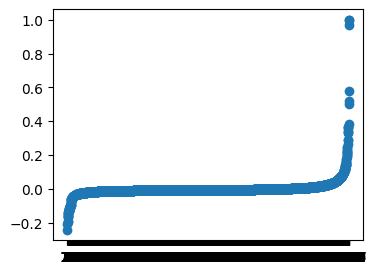

In [24]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (4,3)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [25]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [26]:
eigen_gap_df

,Index,Gap
2704,2704,3.918217e-01
2701,2701,1.210177e-01
2703,2703,6.077478e-02
2694,2694,4.015015e-02
0,0,3.161819e-02
...,...,...
1704,1704,2.233622e-07
1031,1031,1.726841e-07
969,969,1.608088e-07
1289,1289,1.262306e-07


In [27]:
eigen_gap_df[eigen_gap_df['Index'] < 10]

,Index,Gap
0,0,0.031618
3,3,0.021224
1,1,0.014777
8,8,0.010377
5,5,0.007633
2,2,0.006782
6,6,0.005522
7,7,0.001493
4,4,0.001188
9,9,0.000930


In [29]:
# Eigen features for k
k = 7
X = v[:, -1*k:]